In [72]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import matplotlib
matplotlib.rcParams['figure.figsize'] = [18,4]
import matplotlib.style
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
pd.set_option("display.max_colwidth", None)
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count

def launchDask():
    #TODO try, except
    gateway = Gateway()
    options = gateway.cluster_options()
    options.worker_memory=16
    clusters = gateway.list_clusters()
    clusters
    if len(clusters) >0:
        cluster = gateway.connect(clusters[0].name)
        print("using existing connection")#or shut down and start afresh cluster.shutdown(). otherwise I dunno how to apply custom options
        cluster.shutdown()
        cluster = gateway.new_cluster(options)
    else:
        cluster = gateway.new_cluster(options)
    return(cluster)
from dask_gateway import Gateway
from dask.distributed import Client
cluster = launchDask()
from distributed import Client
client = Client(cluster)
client
cluster.adapt(minimum=0, maximum=10)  

using existing connection


In [73]:
from distributed import Client
client = Client(cluster)
client

cluster.adapt(minimum=0, maximum=30)  

In [74]:
client

Client Scheduler: gateway://traefik-daskhub-dask-gateway.daskhub:80/daskhub.fc2a245bea57468c8b2750008fff9297 Dashboard: /services/dask-gateway/clusters/daskhub.fc2a245bea57468c8b2750008fff9297/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [45]:
import boto3
s3 = boto3.resource('s3')

#s3 = boto3.client("s3", 
 #                 region_name='us-west-2', aws_access_key_id='', aws_secret_access_key='')

key='cmip6-pds/s3-inventory-config/data/918e936a-8365-4b42-877b-74e99f18a972.parquet'
#response = s3.head_object(Bucket='s3-inventory-collection', Key=key)

my_bucket = s3.Bucket('s3-inventory-collection')

z_inv_list='s3://s3-inventory-collection/cmip6-pds/s3-inventory-config/hive/dt=2021-04-01-00-00/symlink.txt'
zsym = pd.read_csv(z_inv_list, delimiter='\n',dtype='unicode',index_col=False,header=None)
plist = zsym[0].tolist()
psize = 0                   
for file in my_bucket.objects.all():
        for p in plist:
            p = p.split("s3://s3-inventory-collection/")[1]
            if p in file.key:
                       print(file.key,file.size)
                       psize = psize +file.size
print(psize)


cmip6-pds/s3-inventory-config/data/17785fcb-a301-4624-b62f-cd5b029b5bee.parquet 15643140
cmip6-pds/s3-inventory-config/data/1cf5b7fe-b687-4b9f-88ee-a45f0851fcae.parquet 50375152
cmip6-pds/s3-inventory-config/data/2afc11e8-2b6b-43e5-8f9c-394ee43c3d9a.parquet 50367768
cmip6-pds/s3-inventory-config/data/487157bf-aaa1-4fa0-ac77-dc5317965b58.parquet 10306258
cmip6-pds/s3-inventory-config/data/5561fc17-2fa8-4481-bbed-fcd943ed0ade.parquet 15599062
cmip6-pds/s3-inventory-config/data/71c21377-94cc-4344-ba69-8a6f720ca142.parquet 14704894
cmip6-pds/s3-inventory-config/data/793ca5ca-bf7d-48c8-97cf-afb972405d42.parquet 13719386
cmip6-pds/s3-inventory-config/data/918e936a-8365-4b42-877b-74e99f18a972.parquet 50957995
cmip6-pds/s3-inventory-config/data/b35822c4-bff7-4847-b83f-de0510b81596.parquet 10007855
cmip6-pds/s3-inventory-config/data/b5b325d2-6d28-4eeb-86fc-90db6355b540.parquet 15153383
cmip6-pds/s3-inventory-config/data/ba72d988-a719-4cef-a10b-d8032da59c6f.parquet 48893211
cmip6-pds/s3-inventor

In [46]:
def bytesto(bytes, to, bsize=10):
    a = {'k' : 3, 'm': 6, 'g' : 9, 't' : 12}
    return(bytes / pow(bsize, a[to]))
#Usage: bytesto(size_in_bytes,'g')

bytesto(psize,to='g')

0.4634101

<h2>Prepare Input: Inventory lists and intake catalog pointers, read operations,etc.</h2>

In [75]:
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
import os

#z_inv_list = 'symlink.txt' 
z_inv_list='s3://s3-inventory-collection/cmip6-pds/s3-inventory-config/hive/dt=2021-04-01-00-00/symlink.txt'
zsym = pd.read_csv(z_inv_list, delimiter='\n',dtype='unicode',index_col=False,header=None)

##zarr_inventory_pd = pd.concat(map(pd.read_parquet, (zsym[0].tolist()) ))
##zarr_inventory_pd=zarr_inventory_pd[zarr_inventory_pd['size'].notna()] 

zarr_inventory_dd = dd.read_parquet(zsym[0].tolist(), columns=['key', 'size'], engine='pyarrow',storage_options=dict(anon=True))


In [76]:
zarr_inventory_dd.memory_usage()

Dask Series Structure:
npartitions=1
    int64
      ...
dtype: int64
Dask Name: series-groupby-sum-agg, 67 tasks

In [77]:
zarr_inventory_dd=zarr_inventory_dd.repartition(npartitions=40)  #zarr_inventory_dd.npartitions
zarr_inventory_dd.memory_usage()

Dask Series Structure:
npartitions=1
    int64
      ...
dtype: int64
Dask Name: series-groupby-sum-agg, 198 tasks

In [70]:
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count

##print(len(zarr_inventory_pd)) 
## zarr_inventory_pd=zarr_inventory_pd.set_index('key',drop=False)##3588469

##%time zarr_inventory_dd = dd.from_pandas(zarr_inventory_pd,npartitions=24)


In [78]:
zarr_inventory_dd.head(npartitions=16).size


10

In [79]:
zarr_inventory_dd=zarr_inventory_dd.set_index('key',drop=False)##3588469



In [80]:
zarr_inventory_dd['vstore'] = zarr_inventory_dd.apply(
   lambda row: '/'.join([row['key'].split('/v20')[0],'v20'+row['key'].split('v20')[-1].split('/')[0]] ),axis =1).compute() 



/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/dataframe/core.py:4338: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [63]:
#client.persist(zarr_inventory_dd)

Dask Series Structure:
npartitions=4
    int64
      ...
      ...
      ...
      ...
Name: size, dtype: int64
Dask Name: repartition, 4 tasks

In [81]:
zarr_inventory_dd.npartitions


40

In [10]:
#zarr_inventory_dd.reset_index(drop=False)



,vstore,size
npartitions=1,,
,object,int64
,...,...


In [82]:
zarr_inventory_dd = zarr_inventory_dd.groupby(['vstore'])['size'].sum(split_out=40)


In [15]:
#print(zarr_inventory_dd.npartitions)
#zarr_inventory_dd=zarr_inventory_dd.repartition(npartitions=16)  #zarr_inventory_dd.npartitions
#print(zarr_inventory_dd.npartitions)


16
16


In [83]:
zarr_inventory_dd.compute()



vstore
CMIP6/AerChemMIP/BCC/BCC-ESM1/piClim-control/r1i1p1f1/Amon/tauv/gn/v20190701      10725628
CMIP6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1p1f1/Amon/rsds/gn/v20190624              11777175
CMIP6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1p1f1/day/mrsos/gn/v20190601             160967230
CMIP6/AerChemMIP/BCC/BCC-ESM1/ssp370/r2i1p1f1/Amon/rlut/gn/v20190624              11908278
CMIP6/AerChemMIP/BCC/BCC-ESM1/ssp370/r3i1p1f1/Amon/hur/gn/v20190702              228279588
                                                                                   ...    
CMIP6/ScenarioMIP/THU/CIESM/ssp245/r1i1p1f1/Omon/tauvo/gn/v20200417              337939148
CMIP6/ScenarioMIP/THU/CIESM/ssp585/r1i1p1f1/Amon/hur/gr/v20200605               2972171202
CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp126/r1i1p1f2/Omon/hfds/gn/v20190731            39406243
CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp245/r1i1p1f2/Amon/ua/gn/v20190731             402438153
CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp370/r1i1p1f2/Amon/hurs/gn/v20190731            2

In [ ]:
#zarr_inventory_dd['vstore'] = zarr_inventory_dd.apply(
 #  lambda row: '/'.join([row['key'].split('/v20')[0],'v20'+row['key'].split('v20')[-1].split('/')[0]] ),axis =1).persist() 



In [84]:
zarr_inventory_dd = zarr_inventory_dd.to_frame()


In [22]:
#zarr_inventory_dd=zarr_inventory_dd.repartition(npartitions=40)  #zarr_inventory_dd.npartitions

In [85]:
zarr_inventory_dd.npartitions

40

In [86]:
#zarr_inventory_dd = zarr_inventory_dd.to_frame()
zarr_inventory_dd

,size
npartitions=40,
,int64
,...
...,...
,...
,...


In [87]:
zarr_inventory_dd = zarr_inventory_dd.reset_index(drop=False)

In [88]:
zarr_inventory_dd.head(npartitions=1)

,vstore,size
0,CMIP6/AerChemMIP/BCC/BCC-ESM1/piClim-control/r1i1p1f1/Amon/tauv/gn/v20190701,10725628
1,CMIP6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1p1f1/Amon/rsds/gn/v20190624,11777175
2,CMIP6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1p1f1/day/mrsos/gn/v20190601,160967230
3,CMIP6/AerChemMIP/BCC/BCC-ESM1/ssp370/r2i1p1f1/Amon/rlut/gn/v20190624,11908278
4,CMIP6/AerChemMIP/BCC/BCC-ESM1/ssp370/r3i1p1f1/Amon/hur/gn/v20190702,228279588


In [31]:
#zarr_inventory_dd[zarr_inventory_dd['vstore'] == 'CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hurs/gr/v20200117']


In [89]:
zarr_cat = 'https://cmip6-pds.s3.amazonaws.com/compare/pangeo-cmip6-noQC.csv.gz' 

dzarr = pd.read_csv(zarr_cat, dtype='unicode')
ddzarr = dd.from_pandas(dzarr, npartitions=40)
#ddzarr['vstore']=ddzarr.map_partitions(
#      lambda dzarr : dzarr.apply(
#          lambda row: lambda row: (row.zstore.split('s3://cmip6-pds/')[-1].split('v20')[0]+'v'+row.version), axis = 1)).compute() #scheduler='threads')

ddzarr['vstore'] = ddzarr.apply(lambda row: (row['zstore'].split('s3://cmip6-pds/')[-1].split('v20')[0]+'v'+row.version), axis = 1).compute()
##.split('/v20')[0],'v20'+row['key'].split('v20')[-1].split('/')[0]] ),axis =1).compute() 



/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/dataframe/core.py:4338: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [90]:
dzarrtmp = ddzarr.merge(zarr_inventory_dd, on='vstore', how='outer', suffixes=['', '_'], indicator=True)
dzarr = dzarrtmp[dzarrtmp._merge=='both']
# dzarr[dzarr['size'].notna()] 
#group by vstore and other facets, take sum of size


In [91]:
len(dzarr)

328091

In [92]:
ddzarr_groupby =dzarr.groupby(['zstore','vstore','version','source_id','table_id','institution_id','variable_id','member_id','grid_label','experiment_id'])#.sum('size').compute()
series_ddzarr = ddzarr_groupby['size'].sum().compute()


In [93]:
dzarr = series_ddzarr.to_frame()

In [94]:
dzarr = dzarr.sort_values(by=['version'])


In [95]:
dzarr

,,,,,,,,,,size
zstore,vstore,version,source_id,table_id,institution_id,variable_id,member_id,grid_label,experiment_id,
s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/hfss/gn/v20170706/,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/hfss/gn/v20170706,20170706,CMCC-CM2-HR4,Amon,CMCC,hfss,r1i1p1f1,gn,highresSST-present,1.482069e+08
s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/tasmin/gn/v20170706/,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/tasmin/gn/v20170706,20170706,CMCC-CM2-HR4,Amon,CMCC,tasmin,r1i1p1f1,gn,highresSST-present,1.087241e+08
s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/vas/gn/v20170706/,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/vas/gn/v20170706,20170706,CMCC-CM2-HR4,Amon,CMCC,vas,r1i1p1f1,gn,highresSST-present,1.477963e+08
s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/prw/gn/v20170706/,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/prw/gn/v20170706,20170706,CMCC-CM2-HR4,Amon,CMCC,prw,r1i1p1f1,gn,highresSST-present,1.421726e+08
s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/ua/gn/v20170706/,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/ua/gn/v20170706,20170706,CMCC-CM2-HR4,Amon,CMCC,ua,r1i1p1f1,gn,highresSST-present,2.571644e+09
...,...,...,...,...,...,...,...,...,...,...
s3://cmip6-pds/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r16i1p1f2/Amon/wap/gn/v20210317/,CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r16i1p1f2/Amon/wap/gn/v20210317,20210317,MIROC-ES2L,Amon,MIROC,wap,r16i1p1f2,gn,historical,1.063964e+09
s3://cmip6-pds/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r27i1p1f2/Amon/tas/gn/v20210317/,CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r27i1p1f2/Amon/tas/gn/v20210317,20210317,MIROC-ES2L,Amon,MIROC,tas,r27i1p1f2,gn,historical,4.073076e+07
s3://cmip6-pds/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r18i1p1f2/Amon/pr/gn/v20210317/,CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r18i1p1f2/Amon/pr/gn/v20210317,20210317,MIROC-ES2L,Amon,MIROC,pr,r18i1p1f2,gn,historical,5.446515e+07


In [96]:
type(dzarr)

pandas.core.frame.DataFrame

In [43]:
dzarr.head(1)


,,,,,,,,,,size
zstore,vstore,version,source_id,table_id,institution_id,variable_id,member_id,grid_label,experiment_id,
s3://cmip6-pds/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/evspsbl/gr/v20180608/,CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/evspsbl/gr/v20180608,20180608,E3SM-1-0,Amon,E3SM-Project,evspsbl,r1i1p1f1,gr,piControl,1.239387e+09


In [97]:
#esgf-world catalog
netcdf_cat = 'https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.csv.gz'
dnc = pd.read_csv(netcdf_cat, dtype='unicode')
dnc['key'] = dnc.apply(lambda row: row.path.split('s3://esgf-world/')[-1], axis = 1) #Add key or reuse path as needed--since parquet has the key, for merging later on
#merge dnc and nc_inventory_pd to incorporate size and then remove version duplicates

n_inv_list = 's3://s3-inventory-dest/esgf-world/cmip6-inventory/hive/dt=2021-03-30-00-00/symlink.txt'
nsym = pd.read_csv(n_inv_list, delimiter='\n',dtype='unicode',header=None)
nc_inventory_pd = pd.concat(map(pd.read_parquet, (nsym[0].tolist()) ))
if('is_delete_marker' in nc_inventory_pd): nc_inventory_pd=nc_inventory_pd[nc_inventory_pd['is_delete_marker']==False]    
if('is_latest' in nc_inventory_pd): nc_inventory_pd=nc_inventory_pd[nc_inventory_pd['is_latest']==True]
nc_inventory_pd = nc_inventory_pd[nc_inventory_pd['size'].notna()] 

dnctmp = dnc.merge(nc_inventory_pd, on='key', how='outer', suffixes=['', '_'], indicator=True)
dnetcdf = dnctmp[dnctmp._merge=='both']
dnetcdf = dnetcdf[dnetcdf['size'].notna()] 
dnetcdf = dnetcdf.drop(['frequency', 'modeling_realm'], axis=1) #since its NA in esgf-world csv
dnetcdf['zstore'] = dnetcdf.apply(lambda row: row.key.split('s3://esgf-world/')[-1].split('v20')[0], axis = 1)
dnetcdf['vstore'] = dnetcdf.apply(lambda row: row.zstore + str(row.version)+'/', axis = 1)


#298 in inv, not in intake
#221384 in intake only

<h5>merge dnetcdf and nc_inventory_pd to incorporate size and then remove version duplicates</h5>


<h4>TO BE EXPLAINED -- S3 inventory parquet versus intake_esm catalog discrepancies </h4>

In [ ]:
print(len(dnctmp[dnctmp._merge=='right_only']))
dnctmp_s3only = dnctmp[dnctmp._merge=='right_only']
#about 298 not in intake catalog- this could be because of elimination of problem files.
#TODO see one example, why did it not make it to intake
print('_nc_0 files',len(dnctmp_s3only[dnctmp_s3only['key'].str.endswith(".nc_0")]))
print('.jnl files',len(dnctmp_s3only[dnctmp_s3only['key'].str.endswith(".jnl")]))
dnctmp_s3key = dnctmp_s3only['key']
dnctmp_s3key.to_csv("delete_from_s3_extraneous.csv", encoding='utf-8', index=False)

In [ ]:
print(len(dnctmp[dnctmp._merge=='left_only']))
print(dnctmp['path'].iloc[1])
print(dnctmp['path'].iloc[0])
#dnctmp[dnctmp._merge=='left_only']['key'] #example



<h4>Optional QA</h4>


In [ ]:
#check for zero byte files
#QA 
nc_zero = nc_inventory_pd[nc_inventory_pd['size']==0]
print(len(nc_zero))
#for i in range(len(nc_zero)):
#    print(nc_zero['key'].iloc[i])

In [ ]:
#optional QA
searchval = "CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/CFmon/ta/gn/v20200318/ta_CFmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc"
#searchval = 'CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/AERmon/ps/gn/v20200318/ps_AERmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc'

nc_inventory_pd.loc[nc_inventory_pd['key'] == searchval]
dnetcdf.loc[dnetcdf['key'] == searchval]


In [ ]:
#QA-crosscheck if needed

#searchval = 'CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/'
#d= dnetcdf.loc[dnetcdf['zstore']== searchval] 
#dd= d.loc[d['version']== 'v20180701']
#print(dd['size'].sum())#264,327,907


In [100]:
#get aggregate size for each "dataset" , group by unique facets OR JUST zstore, but we need the other columns.
#TODO add model

dnetcdf=dnetcdf.groupby(['zstore','model','version','mip_table','institute','variable','ensemble_member','grid_label','experiment_id'], as_index=False).sum('size') #sum()['size'].sum()
dnetcdf = dnetcdf.sort_values(by=['version'])
dnetcdf = dnetcdf.drop_duplicates(subset=["zstore"],keep='last')


#.reset_index()



In [98]:
#dnetcdf

In [101]:
#VERIFY
searchval = 'CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/v20180701/'
dnetcdf.loc[(dnetcdf['version']=='v20180701') & (dnetcdf['institute']=='NOAA-GFDL') & (dnetcdf['experiment_id']=='historical') 
                                                                          & (dnetcdf['mip_table'] == 'Amon')
                                                                          & (dnetcdf['variable'] == 'rlus')]
                                                                    
#size shows aggregate size as desired 
#old version should not be displayed 'v20180701'



,zstore,model,version,mip_table,institute,variable,ensemble_member,grid_label,experiment_id,size
73262,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/,GFDL-CM4,v20180701,Amon,NOAA-GFDL,rlus,r1i1p1f1,gr1,historical,264327907.0


<h4>Compare buckets <h4>


<h5>Data volumes of cmip6-pds and esgf-world as a whole, considering latest DRS versions<h5>

In [102]:
#TODO for zarr
dzarr = dzarr.reset_index()

set_L = set(dzarr.zstore.unique())
set_G = set(dnetcdf.zstore.unique())

print('AWS-zarr (number of datasets): ',len(set_L),' AWS-netcdf (number of datasets):', len(set_G),' both (number of datasets):', len(set_G.union(set_L)))


AWS-zarr (number of datasets):  328091  AWS-netcdf (number of datasets): 241747  both (number of datasets): 569838


In [103]:
def bytesto(bytes, to, bsize=10):
    a = {'k' : 3, 'm': 6, 'g' : 9, 't' : 12}
    return(bytes / pow(bsize, a[to]))
#Usage: bytesto(size_in_bytes,'g')

In [104]:
#LATEST DRS VERSIONS 
print("AWS-netcdf in TB",bytesto(dnetcdf['size'].sum(),'t')) #
print("AWS-zarr in TB",bytesto(dzarr['size'].sum(),'t')) #

#DETERMINE what's common TODO 


AWS-netcdf in TB 615.258530535545
AWS-zarr in TB 877.622717543643


In [ ]:
#print("So many filtered from removing old versions:", (total_from_parquet-bytesto(dnetcdf['size'].sum(),'t'))) 

<h4> Visual Comparison </h4>

In [105]:
dnetcdf['activity_id'] = dnetcdf.apply(lambda row: row.zstore.split('s3://esgf-world/CMIP6')[-1].split('/')[1], axis = 1)


In [106]:
#dnetcdf['vstore'] = dnetcdf.apply(lambda row: '/'.join((row.path.split('s3://esgf-world/CMIP6')[-1].split('/')[0:-1])), axis = 1)
dnetcdf['vstore'] = dnetcdf.apply(lambda row: '/'.join((row.zstore,row.version)), axis = 1)


In [107]:
dnetcdf = dnetcdf.rename(columns={"mip_table": "table_id","institute":"institution_id","variable":"variable_id"})

In [108]:
dzarr['activity_id'] = dzarr.apply(lambda row: row.zstore.split('s3://cmip6-pds/CMIP6')[-1].split('/')[1], axis = 1)


In [109]:
dcpp_nc = len(dnetcdf[dnetcdf.activity_id == 'DCPP'])
dcpp_zarr = len(dzarr[dzarr.activity_id == 'DCPP'])

We are not accounting for DCPP at this time since the definition of a dataset is yet to be determined here. 

In [110]:
dZR = dzarr[dzarr.activity_id != 'DCPP']
dNC = dnetcdf[dnetcdf.activity_id != 'DCPP']

In [112]:
m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['', '_'], indicator=True)
dnot_NC = m[m._merge=='left_only']

m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['_', ''], indicator=True)
dnot_ZR = m[m._merge=='right_only']

dZRnNC = dnot_NC[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore','version', 
       'vstore','size']]

dNCnZR = dnot_ZR[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore','version', 
       'vstore','size']]


'''
dZRnNC = dnot_NC[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version', 'status', 'severity', 'issue_url',
       'vstore','size']]

dNCnZR = dnot_ZR[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version', 'status', 'severity', 'issue_url',
       'vstore','size']]

'''
'''
print('For all activities other than DCPP:')
print('AWS-zarr:  ', len(dZR),'datasets')
print('AWS-netcdf:', len(dNC),'datasets')
print('zarrs with no matching netcdfs:',len(dZRnNC),'datasets')
print('netcdfs with no matching zarrs: ',len(dNCnZR),'datasets')
'''
aws_zarr= len(dZR)
aws_nc = len(dNC)
zarr_MissingNC = len(dZRnNC)
nc_MissingZarr = len(dNCnZR)
in_both = aws_zarr - zarr_MissingNC
num_all = aws_zarr+aws_nc-in_both

print('DCPP (netcdf) datasets attribute to', dcpp_nc)
print('DCPP (zarr) datasets attribute to', dcpp_zarr)
print('For all activities other than DCPP, total unique datasets from both:', num_all )
print('S3/zarr has:  ',aws_zarr)
print('S3/netcdf has:',aws_nc)
print('S3/zarr needs:  ',nc_MissingZarr) #guestimate 402TB
print('S3/netcdf needs:', zarr_MissingNC )#guestimate 540TB
print('\n What is common in both buckets:',int(100*(in_both)/num_all),'%') #225TB



DCPP (netcdf) datasets attribute to 69619
DCPP (zarr) datasets attribute to 0
For all activities other than DCPP, total unique datasets from both: 500219
S3/zarr has:   328091
S3/netcdf has: 172128
S3/zarr needs:   172128
S3/netcdf needs: 328091

 What is common in both buckets: 0 %


In [113]:
dZR_size= dZR['size'].sum()
dNC_size = dNC['size'].sum()
dNCnZR_size = dNCnZR['size'].sum()
dZRnNC_size = dZRnNC['size'].sum()

in_both_size = dZR_size - dNC_size
num_all_size = dZR_size+dNC_size -in_both

#df_dict_size = {'ZARR':dZR_size,'NetCDF':dNC_size,'ZARR but not NetCDF':dZRnNC_size,'NetCDF but not ZARR':dNCnZR_size}


print('For all activities other than DCPP, size of total unique datasets from both:', num_all_size )
print('S3/zarr has:  ',bytesto(dZR_size,'t'))
print('S3/netcdf has:',bytesto(dNC_size ,'t'))
print('S3/zarr needs:  ',bytesto(dNCnZR_size,'t'),'TB') #guestimate 402TB
print('S3/netcdf needs:', bytesto(dZRnNC_size,'t'),'TB')#guestimate 540TB
both_size = bytesto(int(100*(in_both_size)/num_all_size),'t')
print('\n What is common in both buckets:',in_both_size,'T',both_size,'%') #225TB

#NOTE: zarr size is not included yet, says 0, but its NA for now

For all activities other than DCPP, size of total unique datasets from both: 1476171721904128.0
S3/zarr has:   877.622717543643
S3/netcdf has: 598.549004360485
S3/zarr needs:   598.549004360485 TB
S3/netcdf needs: 877.622717543643 TB

 What is common in both buckets: 279073713183158.0 T 1.8e-11 %


In [114]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=10)

In [115]:
def plot_facet(df_dict,facet='table_id',top_n=8,ymax=300000,ylabel='number',title_add='',units='t'):   
    labels = df_dict.keys()
    stables = set()
    for label in labels:
        stables = stables.union(set(df_dict[label][facet].unique()))    
    tables = sorted(list(stables))
    
    vdfs = {}
    for label in labels:
        df = df_dict[label]
        nvdf = []
        for table in tables:
            if("volume" in ylabel):
                ndf = df[df[facet]==table]['size'].sum()
                ndf = round(bytesto(ndf,units))
            else:
                ndf = df[df[facet]==table].vstore.nunique()
            nvdf += [ndf]
        vdfs[label] = nvdf
    
    names = []
    totals = []
    for item,table in enumerate(tables):
        names += [table]
        tsum = 0
        for label in labels:
            tsum += vdfs[label][item]
        totals += [tsum]

    num_dict = {'name': names,'total':totals}
    for label in labels:
        num_dict[label] = vdfs[label]
    
    df_nums = pd.DataFrame(num_dict)  
    
    df_nums = df_nums.sort_values(by=['total'],ascending=False)
    #df_nums = df_nums.sort_values(by=[list(labels)[1]],ascending=False)

    width = 1.0/(1+len(labels))  # the width of the bars
    
    fig, ax = plt.subplots()

    names = df_nums.name.values[:top_n]
    x = np.arange(len(names)) 
    
    for item,label in enumerate(labels):
        vdf = df_nums[label].values[:top_n]
        rects = ax.bar(x - (len(labels)/2-item-0.5)*width, vdf, width, label=label)
        autolabel(ax,rects)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} top {top_n} by {facet}'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    #plt.savefig(f'compare-{facet}.png')

    plt.show()

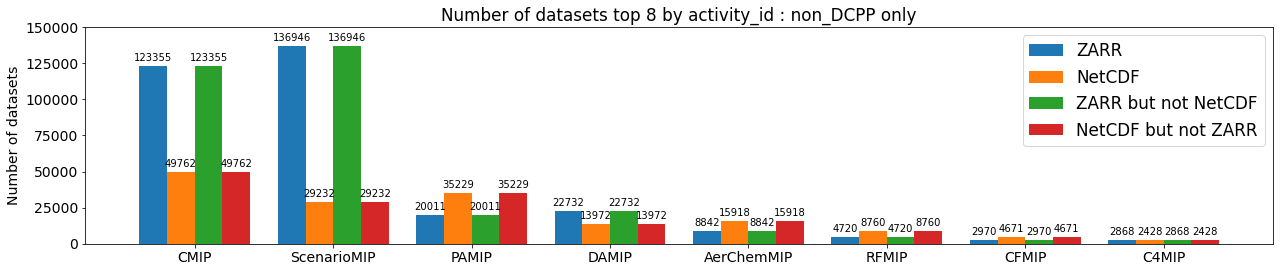

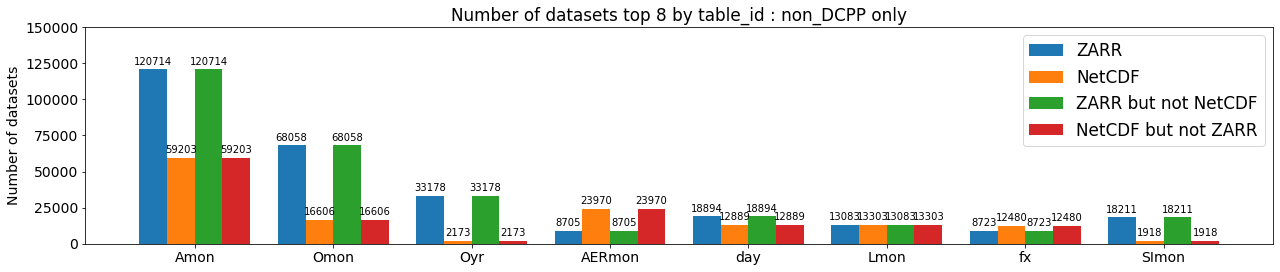

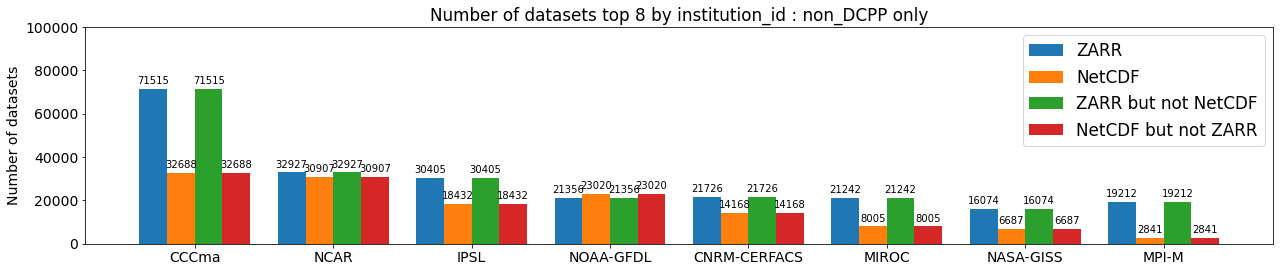

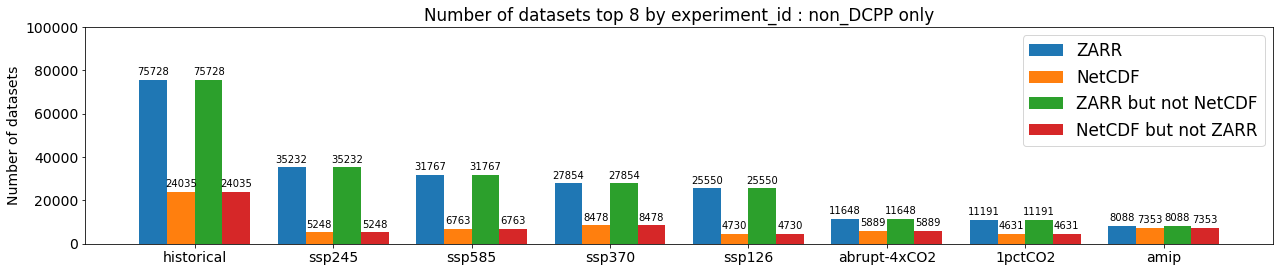

In [116]:
df_dict = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}
plot_facet(df_dict,facet='activity_id',ymax=150000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='table_id',ymax=150000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='institution_id',top_n=8,ymax=100000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='experiment_id',ymax=100000,ylabel='Number of datasets',title_add = ' : non_DCPP only')


In [117]:
dZR.head(0)

,zstore,vstore,version,source_id,table_id,institution_id,variable_id,member_id,grid_label,experiment_id,size,activity_id


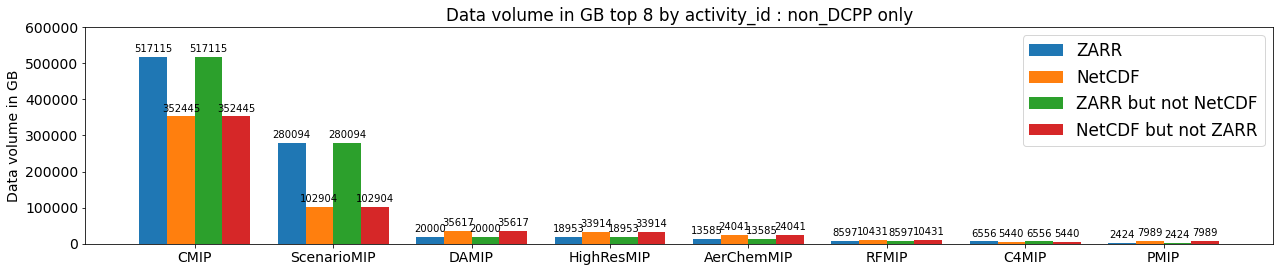

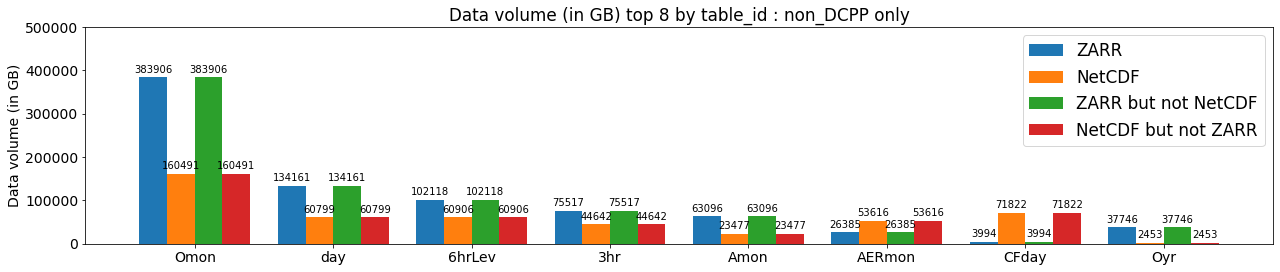

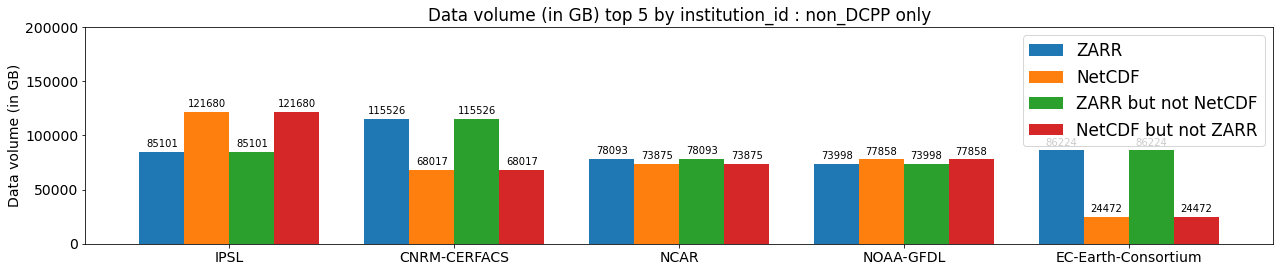

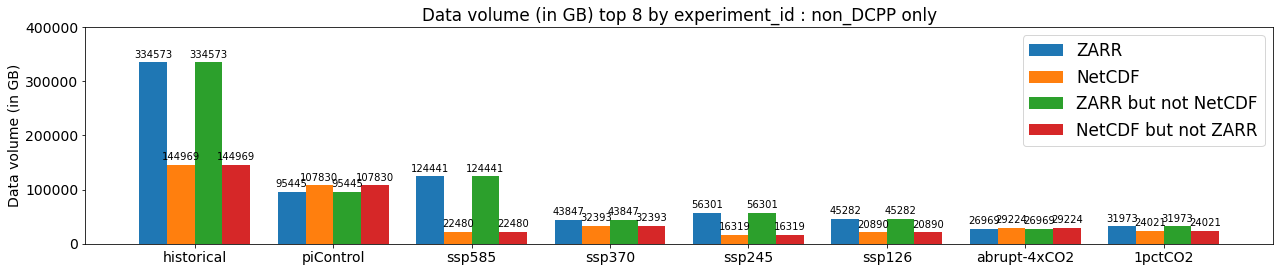

In [121]:
df_dict_size = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}

plot_facet(df_dict_size,facet='activity_id',ymax=600000, ylabel='Data volume in GB',title_add = ' : non_DCPP only',units='g')
plot_facet(df_dict_size,facet='table_id',ymax=500000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only',units='g')
plot_facet(df_dict_size,facet='institution_id',top_n=5,ymax=200000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only',units='g')
plot_facet(df_dict_size,facet='experiment_id',ymax=400000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only',units='g')


In [ ]:
dZRm = dZR[dZR.table_id.str.contains('mon')]
dNCm = dNC[dNC.table_id.str.contains('mon')]
df_dict = {'ZARR':dZRm,'NetCDF':dNCm}
plot_facet(df_dict,facet='variable_id',ymax=30000,title_add = ' : monthly, non_DCPP only',units='g')